In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from ipywidgets import interact, Dropdown

In [2]:
MIN_CASES = 1
PLOT_TYPE = 'Confirmed Cases'

In [3]:
# Load data
import os
def load_cases_from_file():
    confirmed_filename = os.path.join('..','covid-19-cases.csv')
    return pd.read_csv(confirmed_filename)

def load_cases_from_url():
    confirmed_url = ('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/'
            'csse_covid_19_data/csse_covid_19_time_series'
            '/time_series_covid19_confirmed_global.csv')
    return pd.read_csv(confirmed_url)

df = load_cases_from_url()

In [4]:

country_list = df.groupby('Country/Region').sum().index.values
states = df.dropna(subset=['Province/State']).loc[:,('Country/Region','Province/State')]
state_dict = states.groupby('Country/Region')['Province/State'].apply(list).to_dict()


def plot_states_of_country(country):
    state_list = state_dict[country]
    for state in state_list:
        plot_country(country,state)


def plot_country_list(countries):
    for country in countries:
        plot_country(country)


def plot_all_countries():
    """Plot all countries. Caution - Slow!"""
    plot_country_list(country_list)


In [5]:

def prepare_data(country, state = None):
    # Select the country
    prepared_df = df[df['Country/Region'] == country]
    if state is not None :
        prepared_df = prepared_df[prepared_df['Province/State'] == state]
        prepared_df = prepared_df.groupby('Province/State').sum()
    else:
        prepared_df = prepared_df.groupby('Country/Region').sum()

    # select columns that match a date format and convert to int type
    date_pattern = '\\d{1,2}/\\d{1,2}/\\d{1,2}'
    timeseries_df = prepared_df.loc[:, prepared_df.filter(regex=date_pattern).columns ]
    timeseries_df = timeseries_df.astype(int)
    timeseries_df = timeseries_df.T
    # convert column names to datetime values
    timeseries_df.index = pd.to_datetime(timeseries_df.index)
    timeseries_df = timeseries_df.squeeze()

    # discard rows with fewer than MIN_CASES
    timeseries_df = timeseries_df[timeseries_df >= MIN_CASES]
    return timeseries_df    


In [6]:
def plot_country(country, state = None, rolling_days=3):
    # Prepare data
    timeseries_df = prepare_data(country,state)
    n = len(timeseries_df)
    if n == 0:
        print("Not enough data")
        return

    # Plot data
    fig = plt.figure(figsize=(12,8))

    # Arrange the subplots on a grid: the top plot (case number change) is
    # one quarter the height of the bar chart (total confirmed case numbers).
    cases_plt = plt.subplot2grid((4, 1), (1, 0), rowspan=3)
    growth_plt = plt.subplot2grid((4, 1), (0, 0), sharex=cases_plt)

    smoothed = timeseries_df.rolling(rolling_days).mean()
    #smoothed = timeseries_df.ewm(com=0.01).mean() # exponential smoothing

    cases_plt.bar(range(n), timeseries_df.values)
    cases_plt.plot(range(n), smoothed,'k')

    # Force the x-axis to be in integers (whole number of days) in case
    # matplotlib chooses some non-integral number of days to label).
    cases_plt.xaxis.set_major_locator(MaxNLocator(integer=True))
    cases_plt.set_yscale('log')

    # log(n/n-1)
    c_df_change = smoothed.pct_change()
    c_df_change = c_df_change.transform(lambda x: np.log(x*100))
    change_values = c_df_change.values

    #growth_ax.set(xlim=(0,n))
    # Draw a horizontal line
    growth_plt.axhline(y=1.0, color='grey')
    # Plot growth values
    growth_plt.bar(range(n), change_values - 1.0, bottom=1.0)
    #growth_ax.bar(range(n), change_values,bottom=0.0)
    #growth_ax.set_xticks([])
    
    cases_plt.set_xlabel('Days since {} {}'.format(MIN_CASES, PLOT_TYPE))
    cases_plt.set_ylabel(f'Number of {PLOT_TYPE}, $N$')
    growth_plt.set_ylabel('Growth Rate\n$\log(N / N-1)$')
    
    # Add a title reporting the latest number of cases available.
    if state is None:
        region = country
    else:
        region = '{}, {}'.format(state, country)
    title = '{}\n{} {} on {}'.format(region, timeseries_df[-1], PLOT_TYPE,
                                     timeseries_df.index[-1].strftime('%d %B %Y'))
    plt.suptitle(title)
    plt.show()
    # Return fig for interactive plots
    return fig

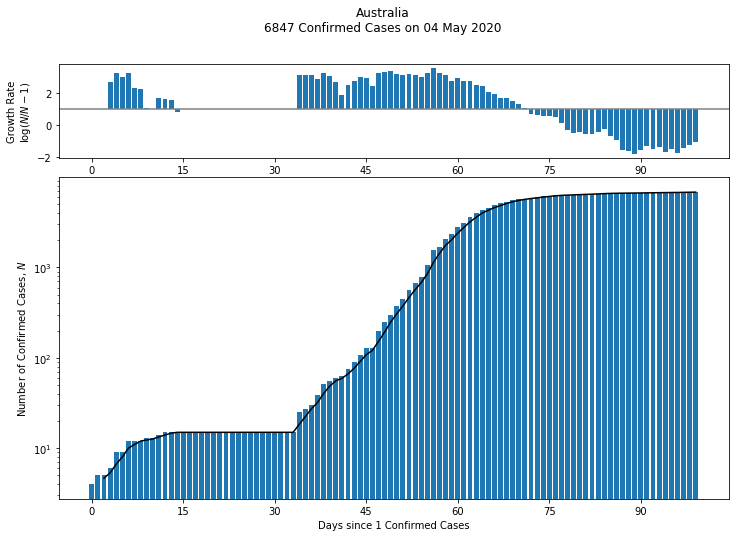

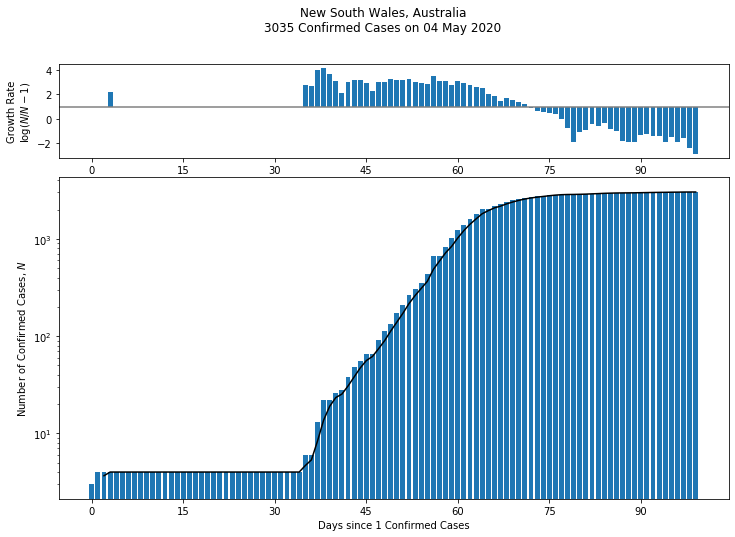

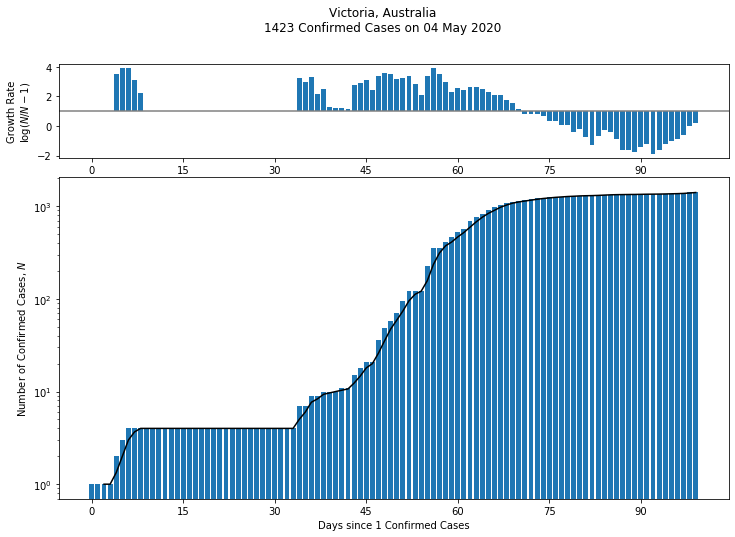

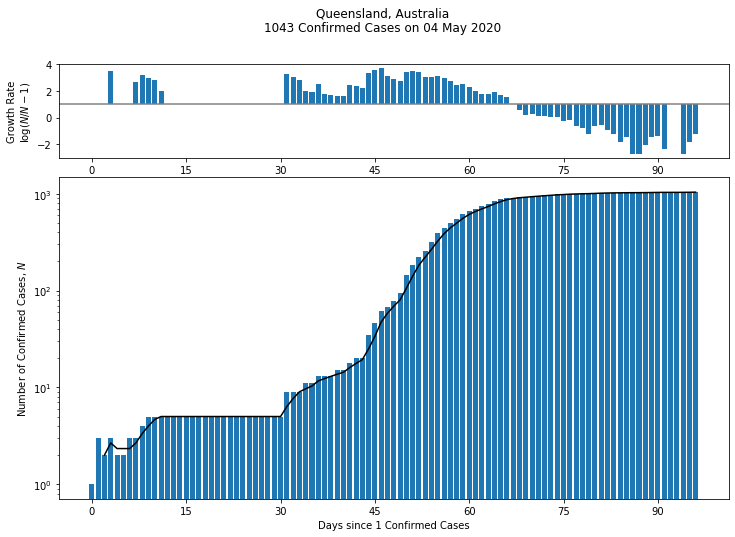

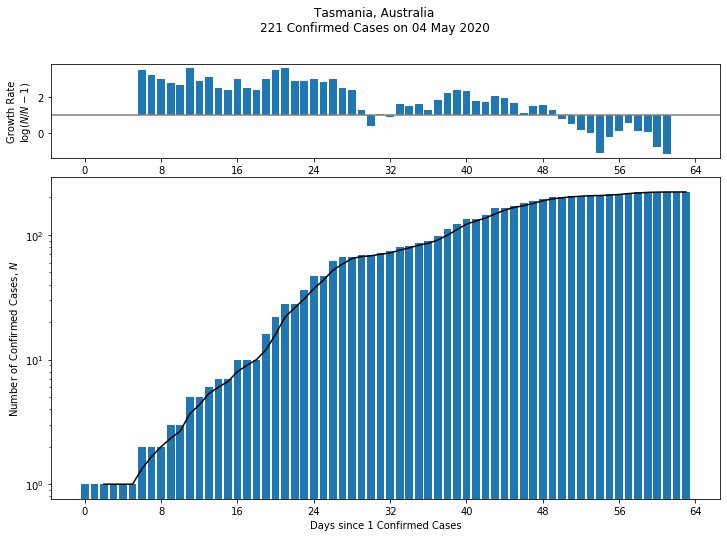

In [7]:
plot_country('Australia')
plot_country('Australia','New South Wales')
plot_country('Australia','Victoria')
plot_country('Australia','Queensland')
plot_country('Australia','Tasmania');

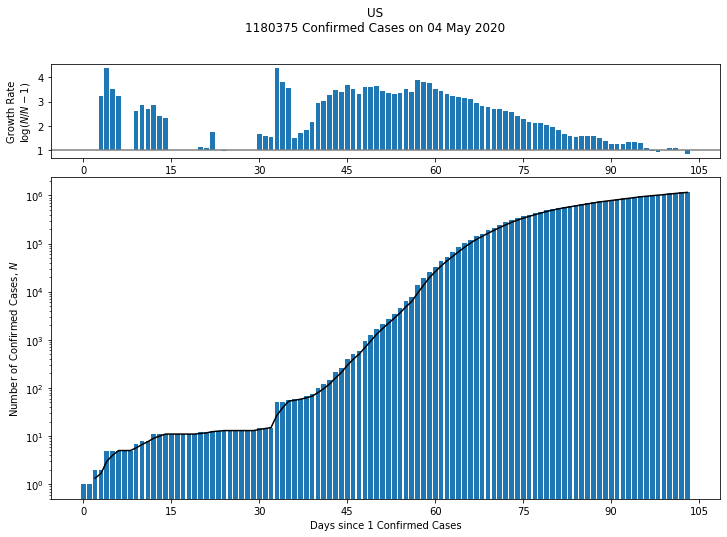

In [8]:
plot_country('US');

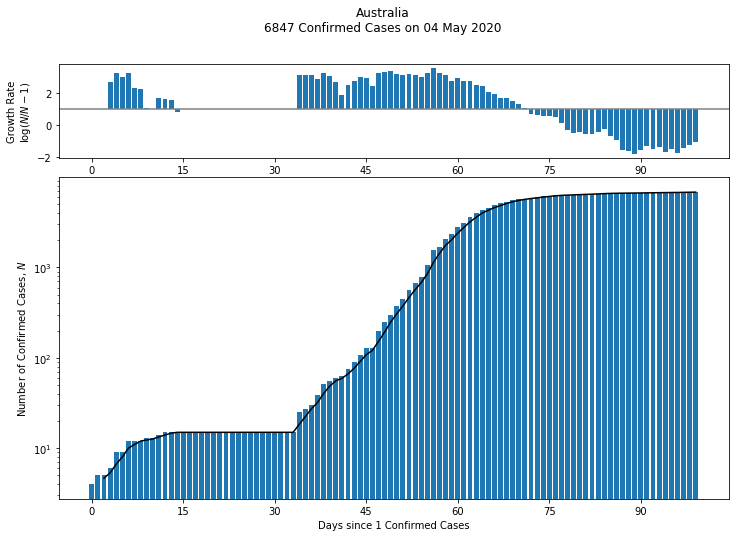

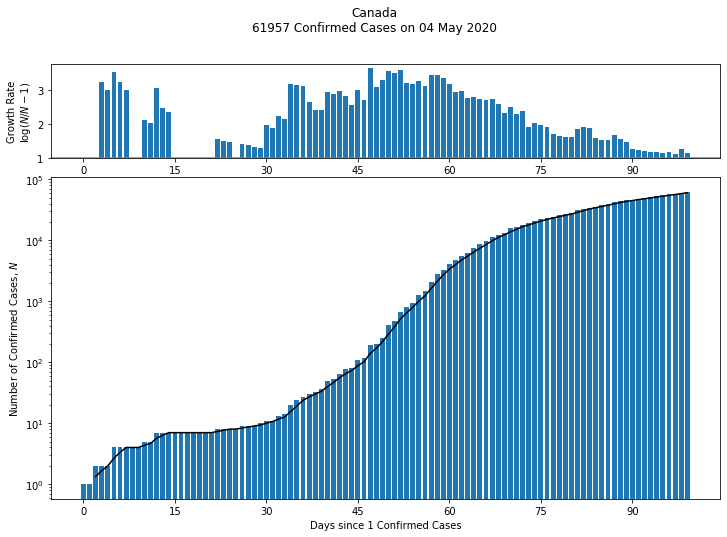

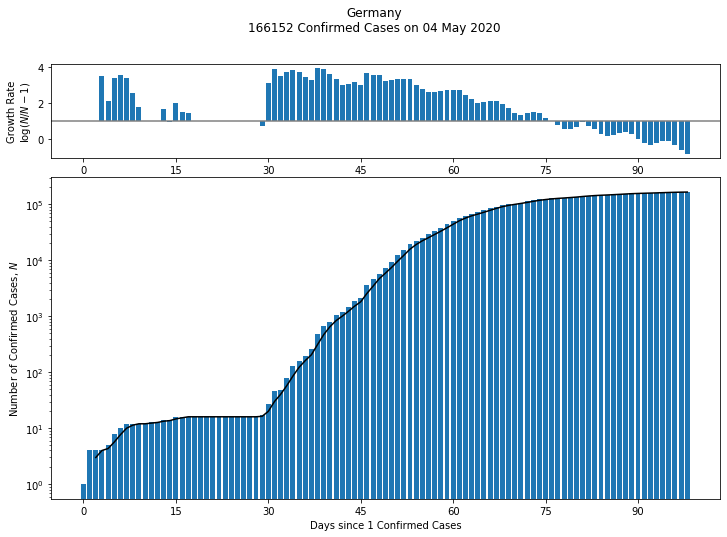

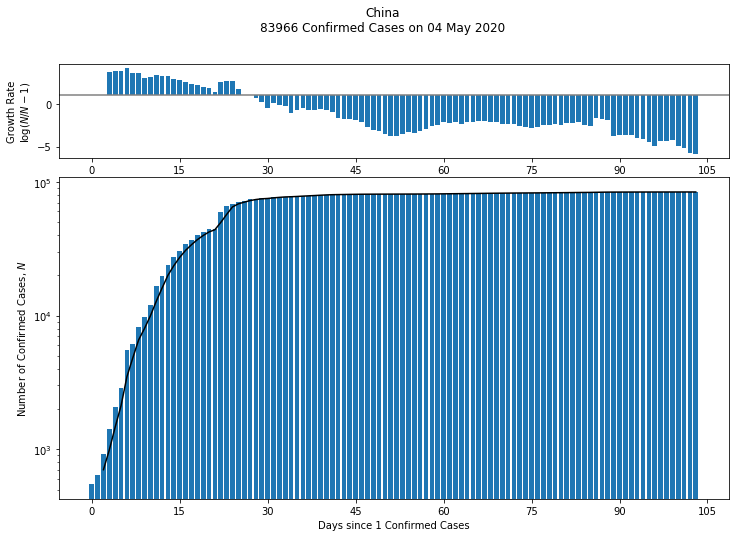

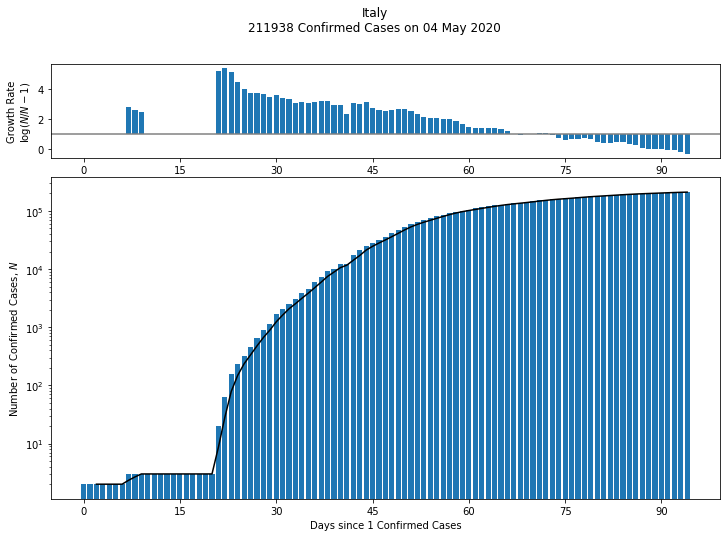

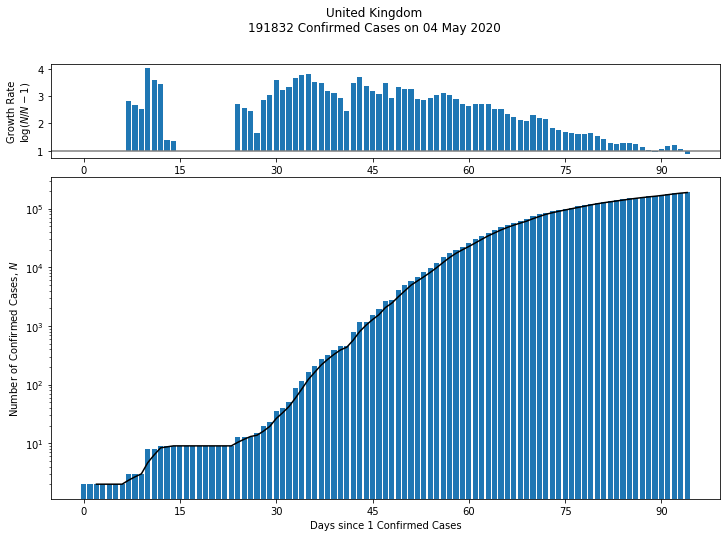

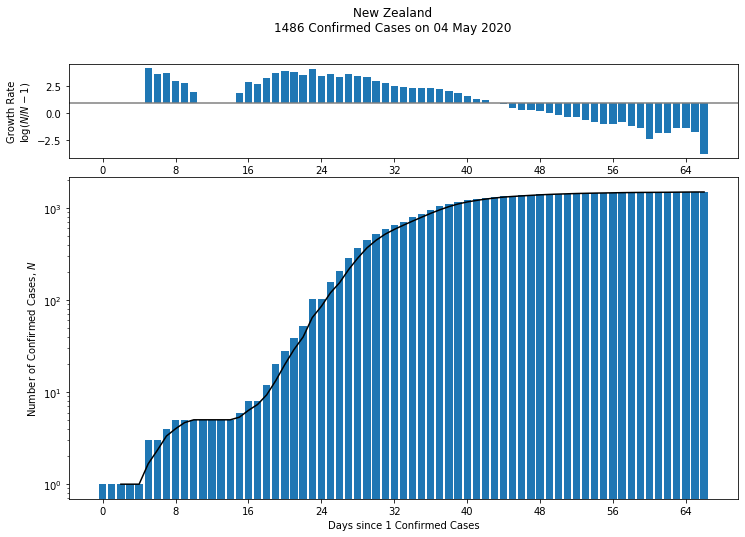

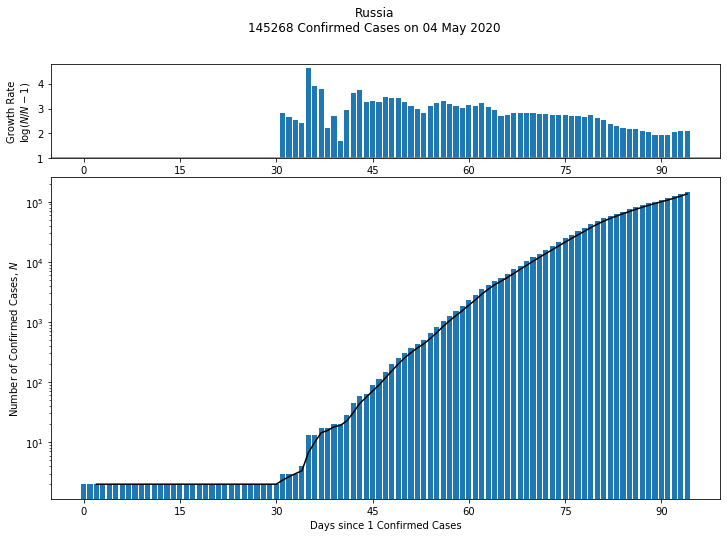

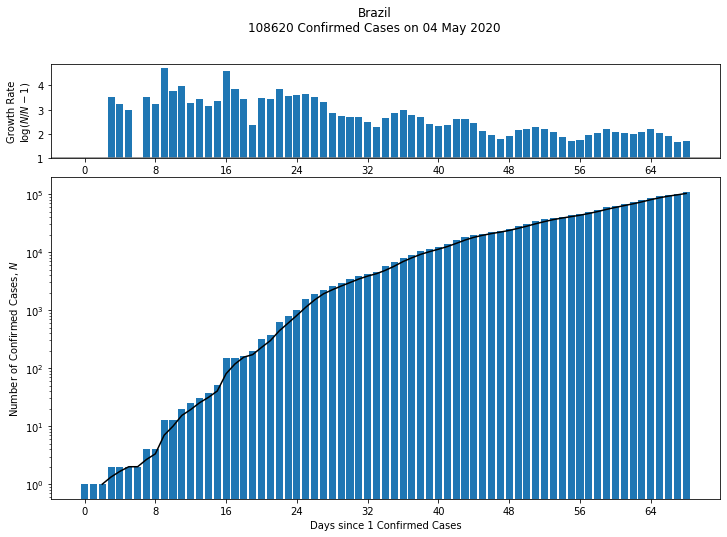

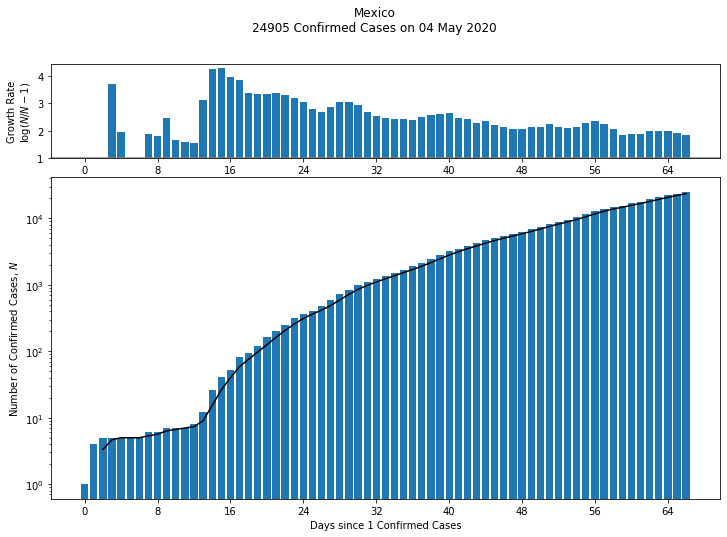

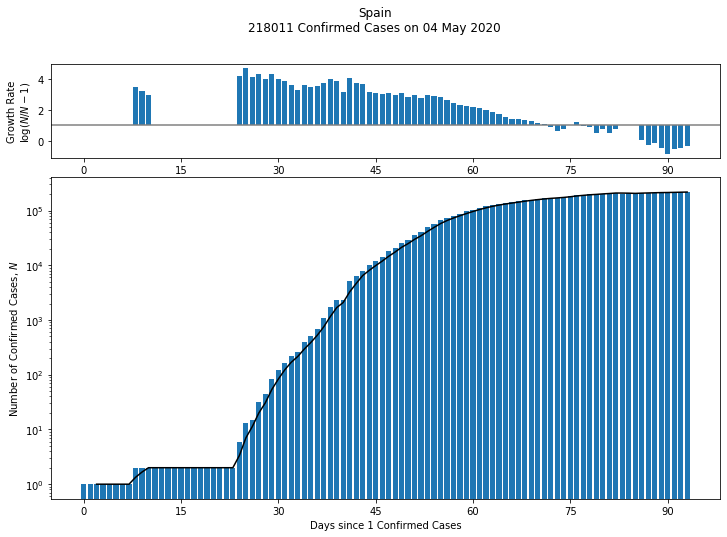

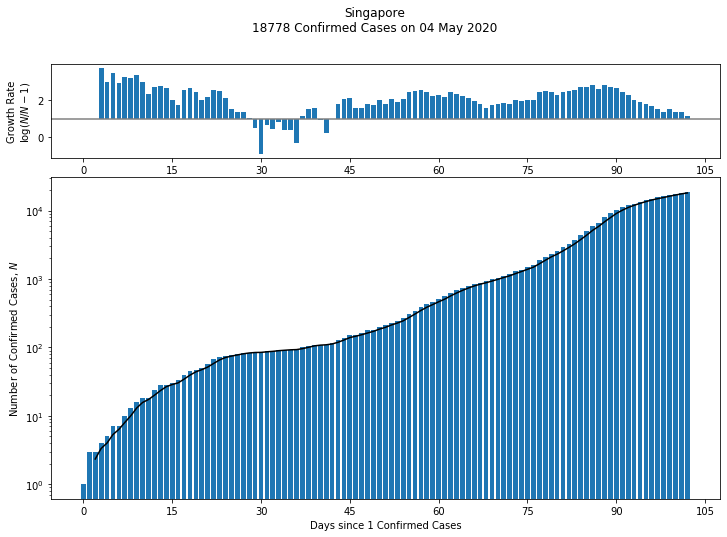

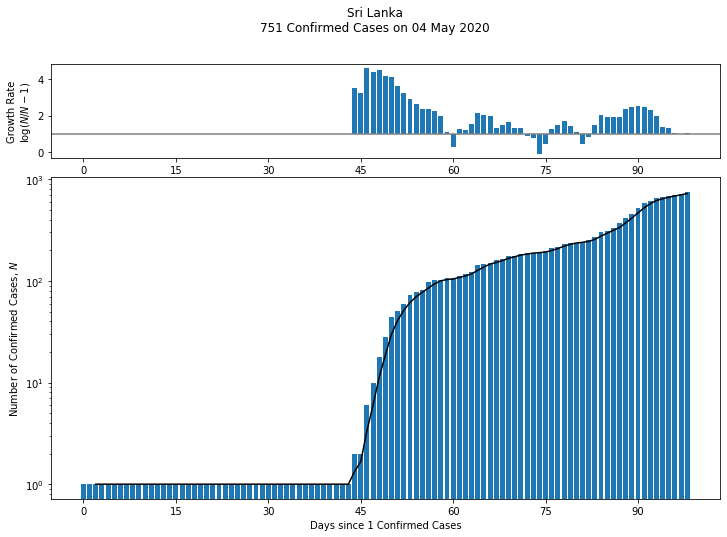

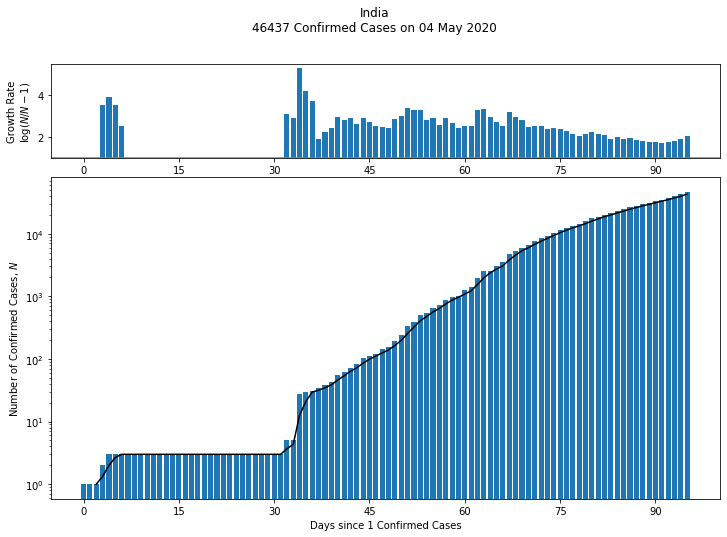

In [9]:
country_plot_list = [
    'Australia',
    'Canada',
    'Germany',
    'China',
    'Italy',
    'United Kingdom',
    'New Zealand',
    'Russia',
    'Brazil',
    'Mexico',
    'Spain',
    'Singapore',
    'Sri Lanka',
    'India']

plot_country_list(country_plot_list)


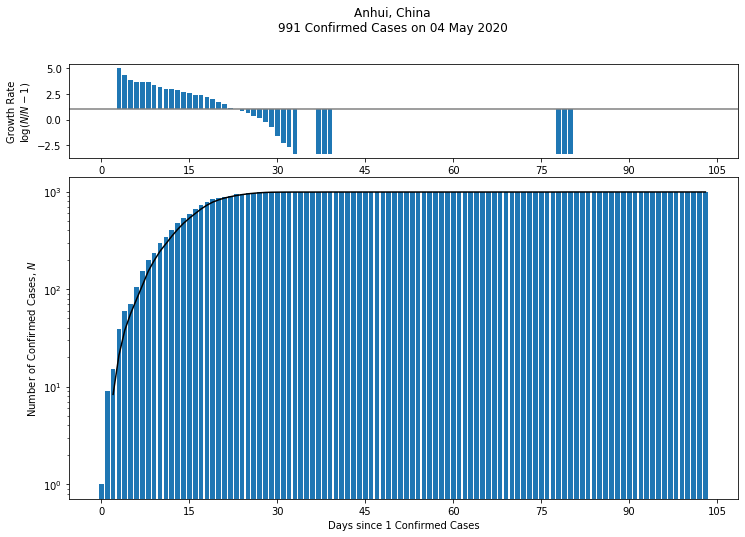

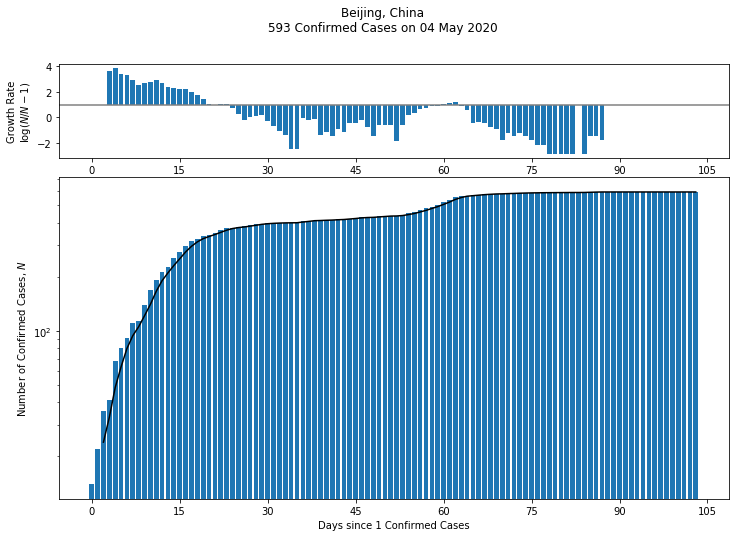

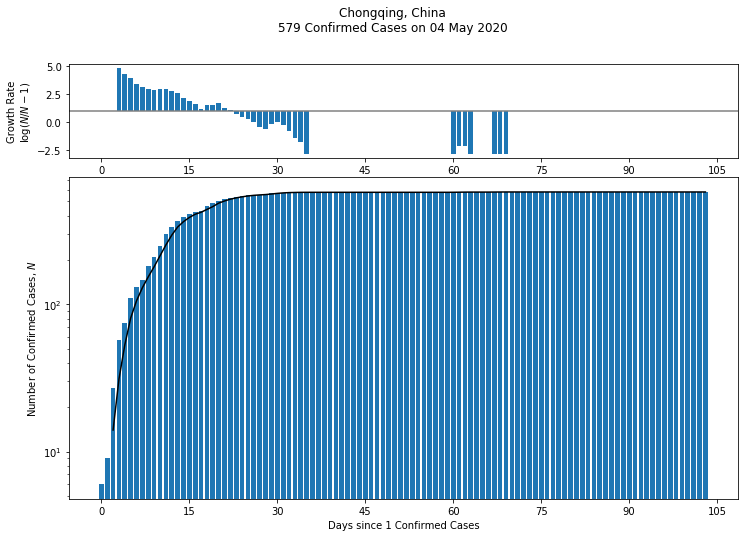

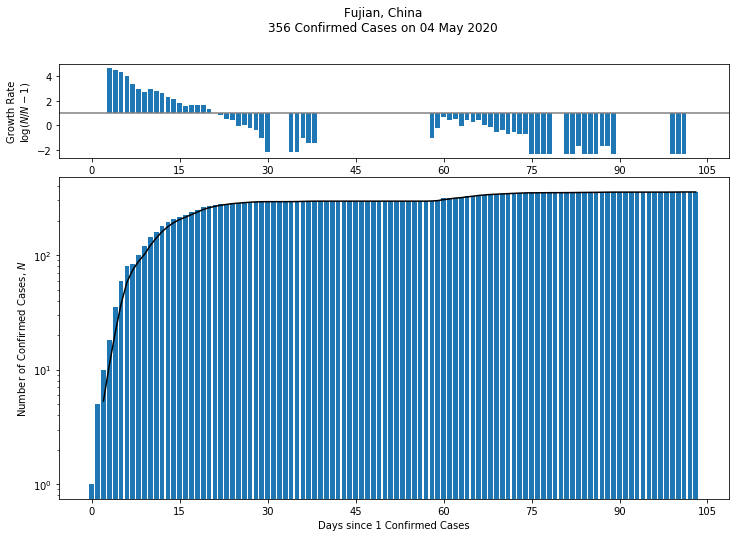

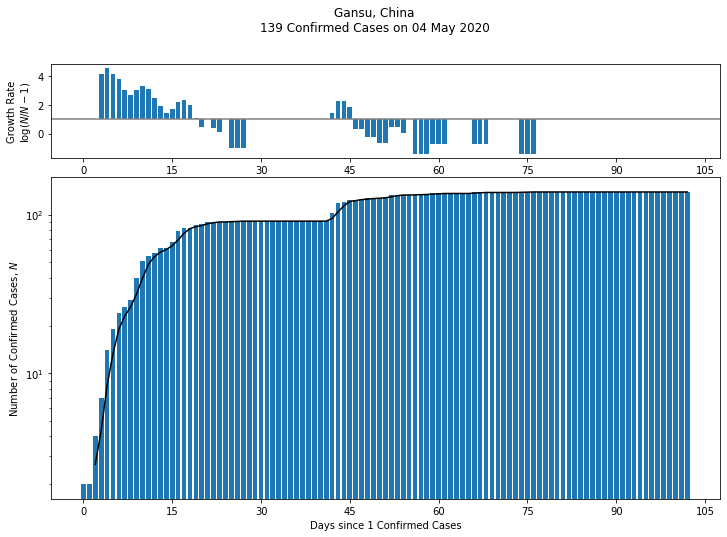

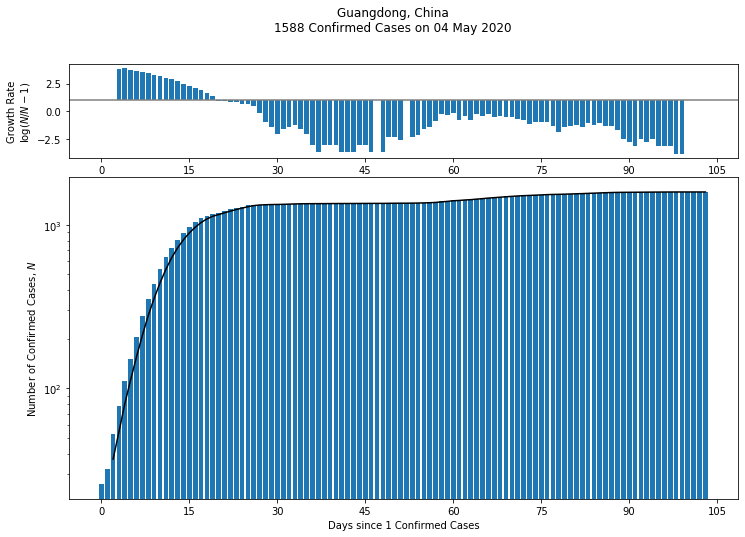

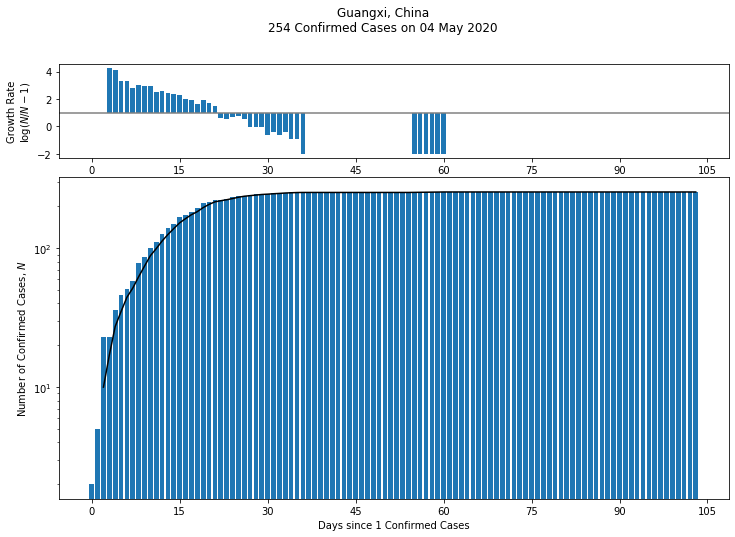

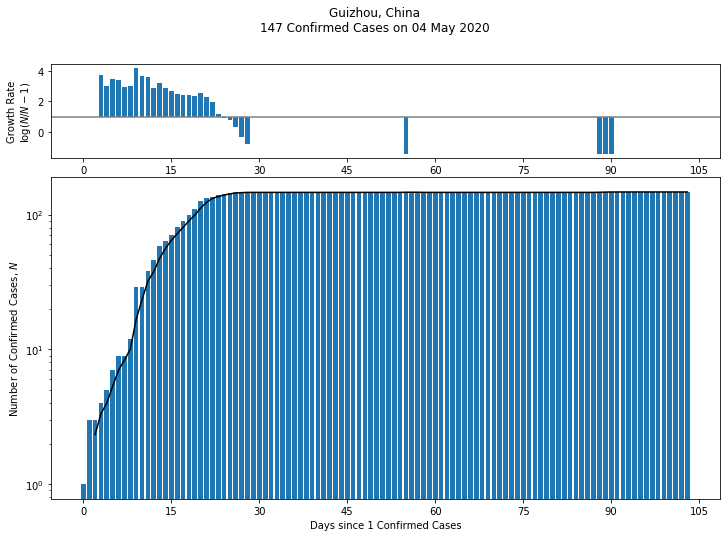

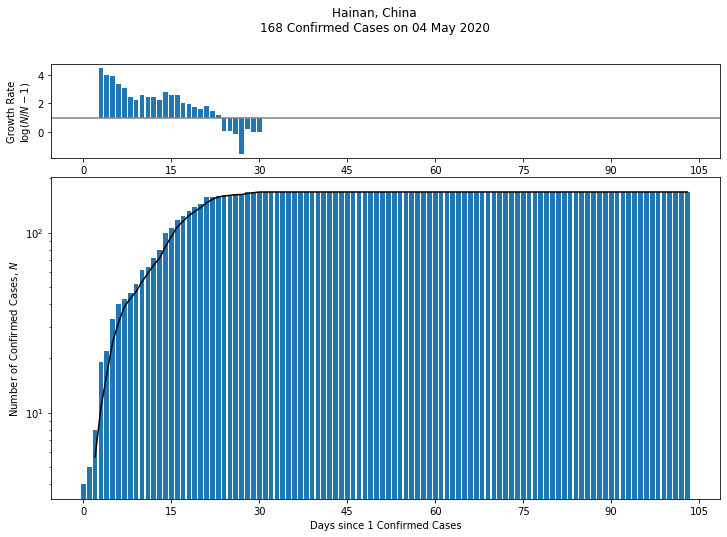

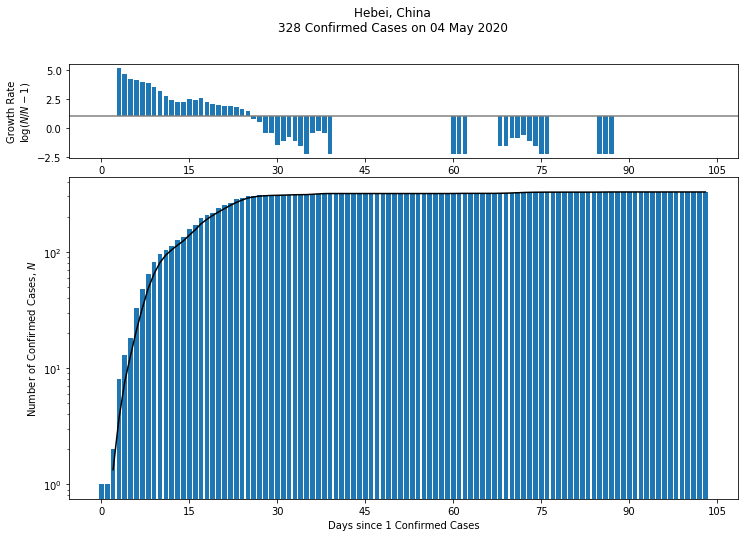

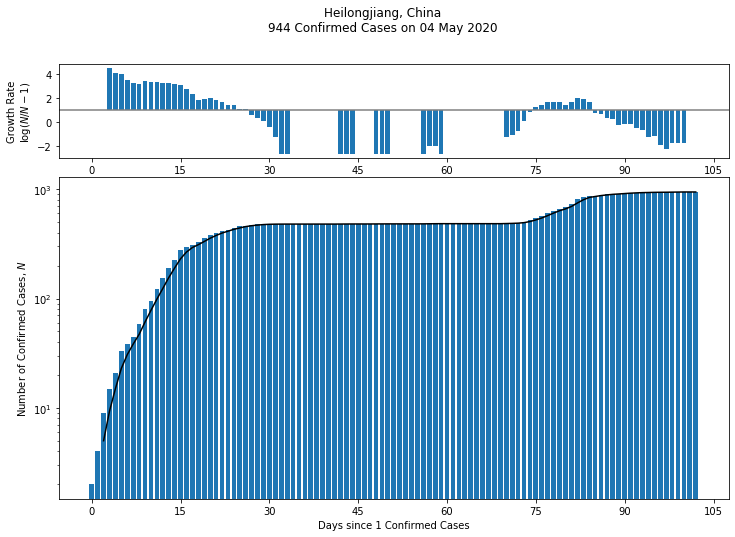

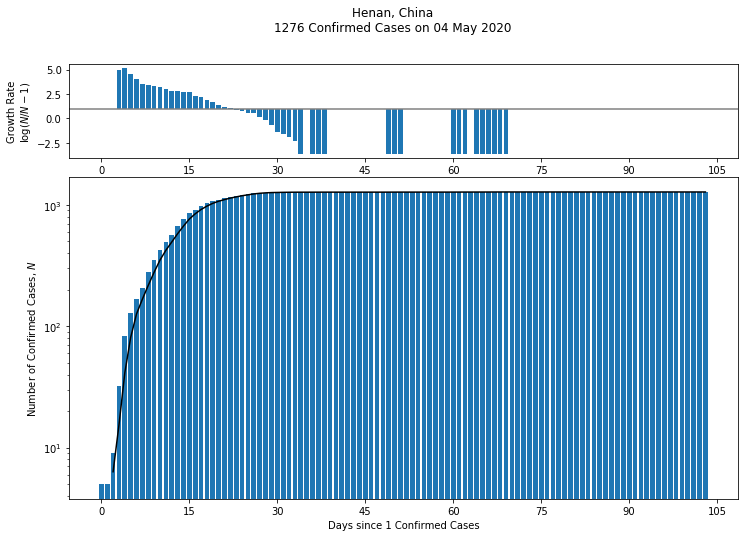

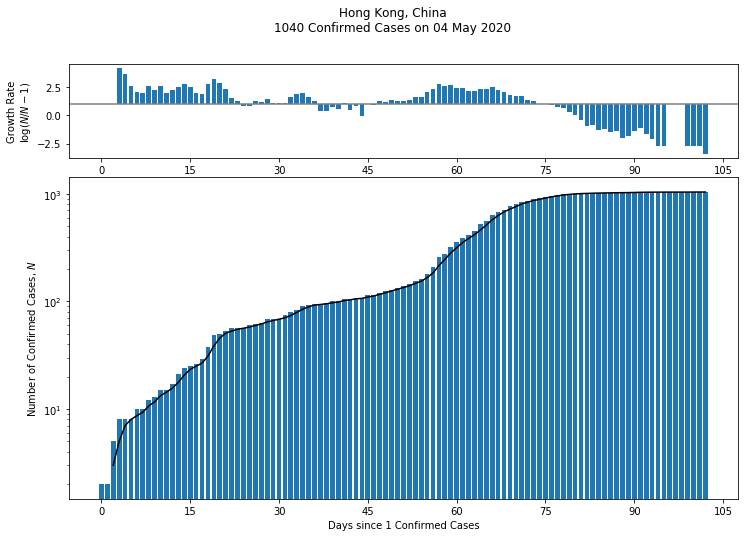

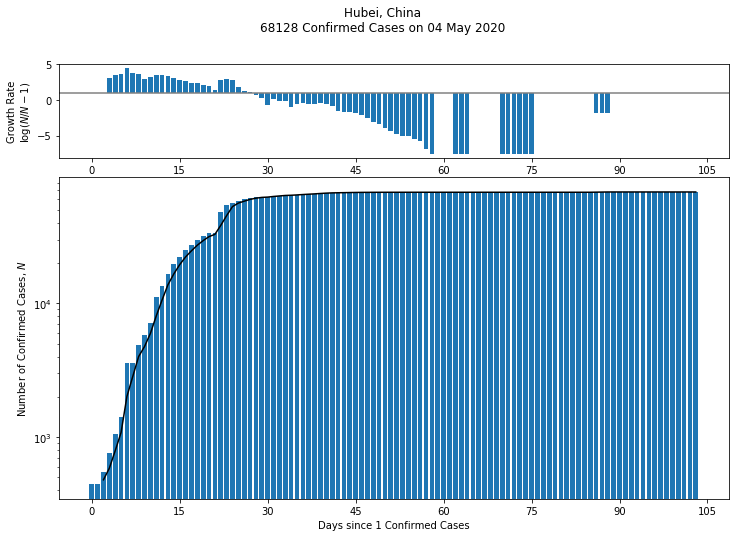

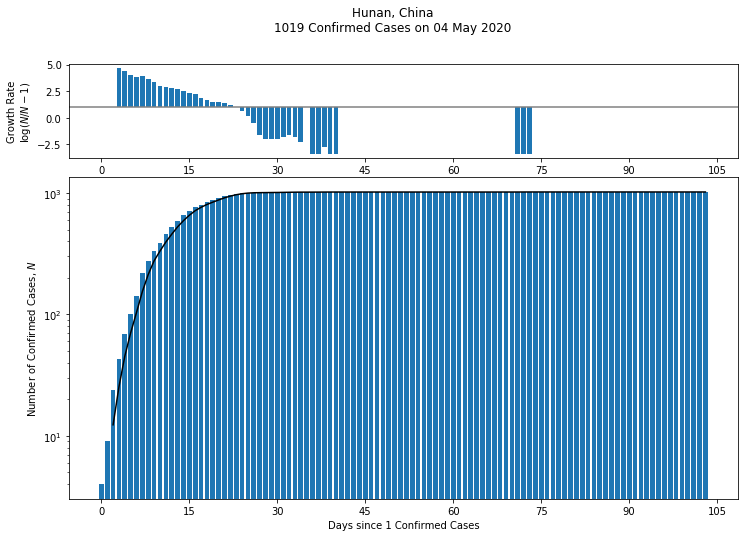

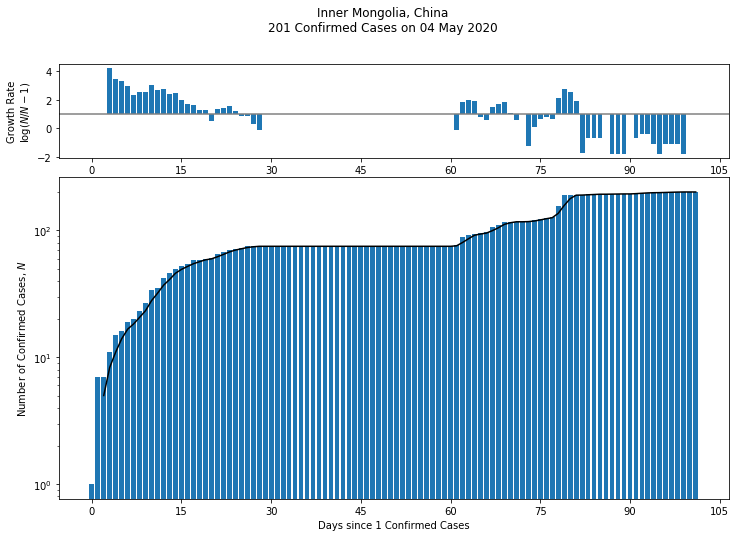

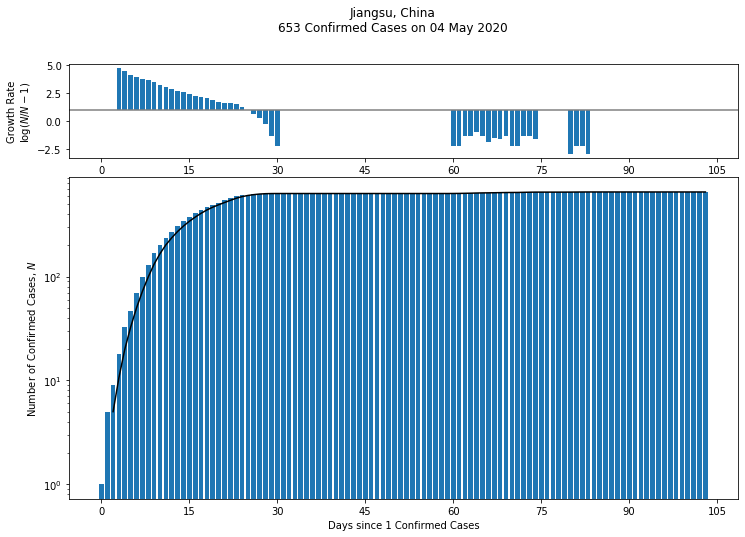

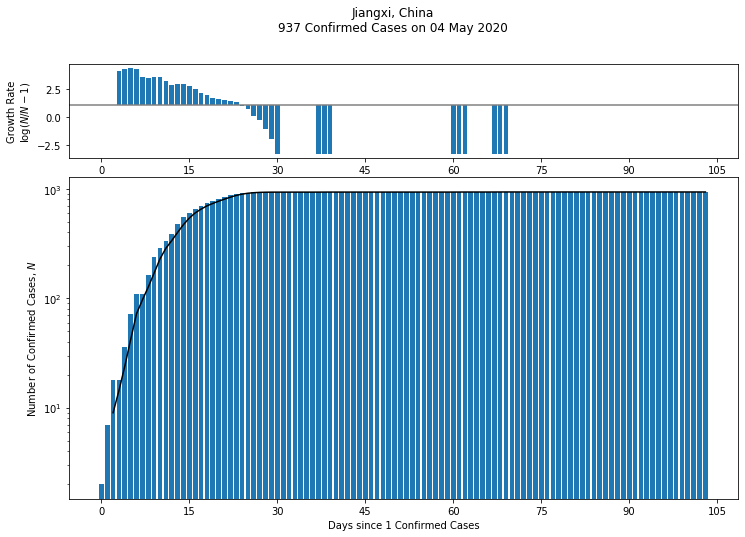

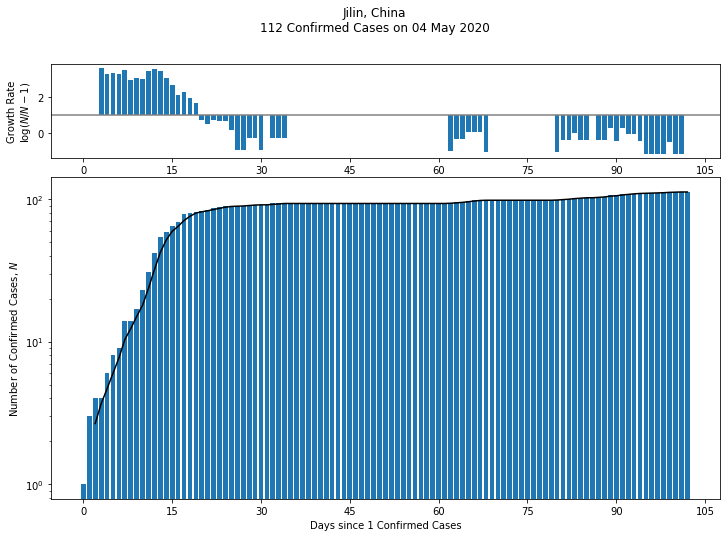

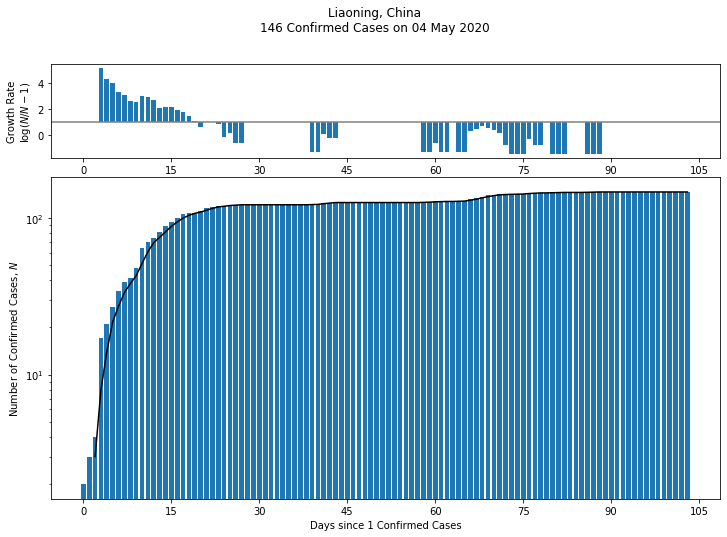

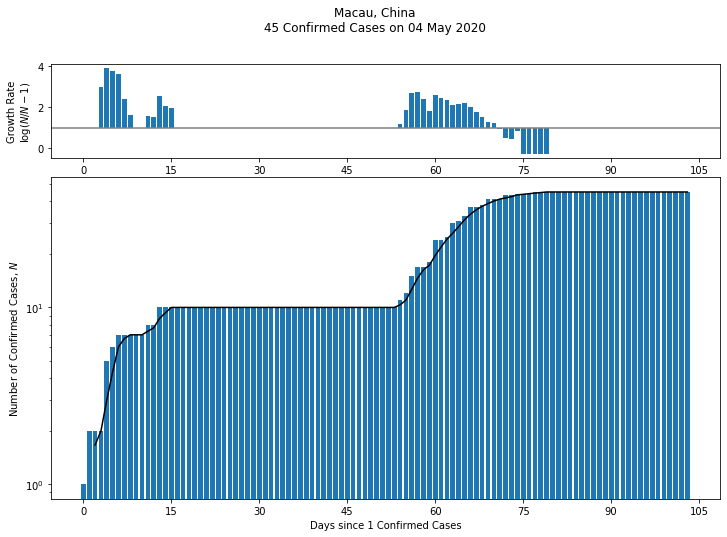

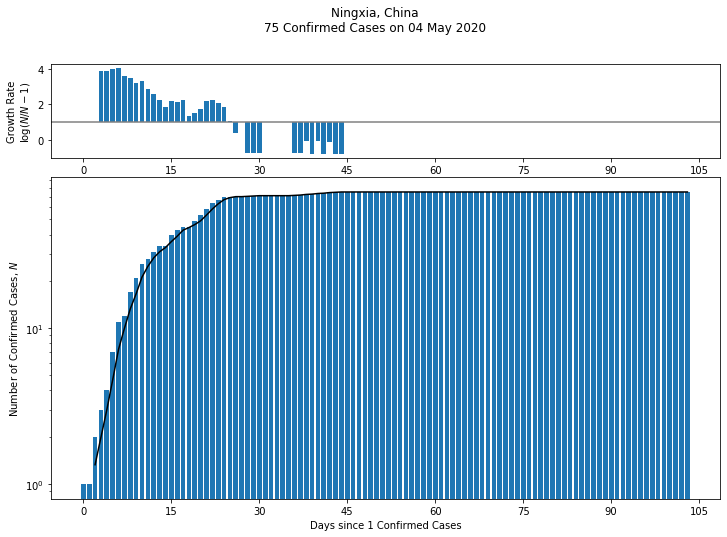

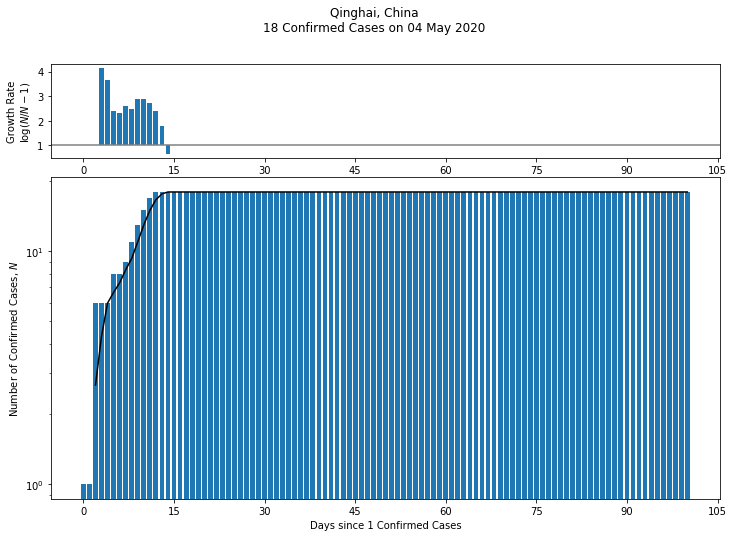

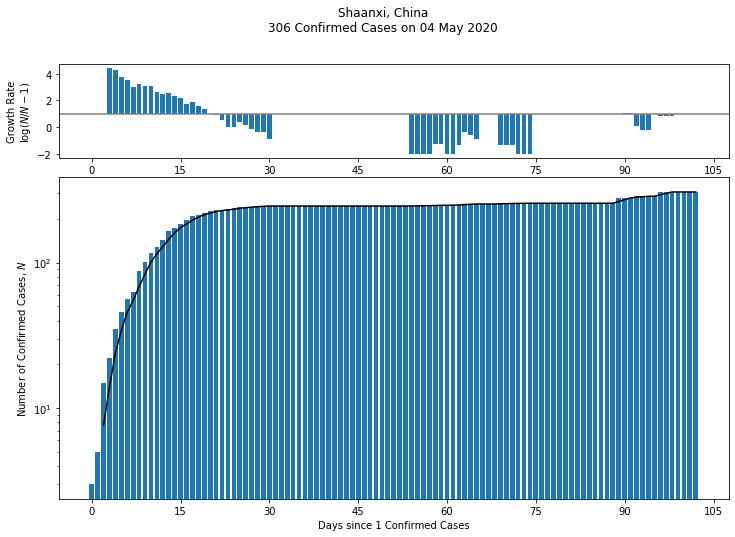

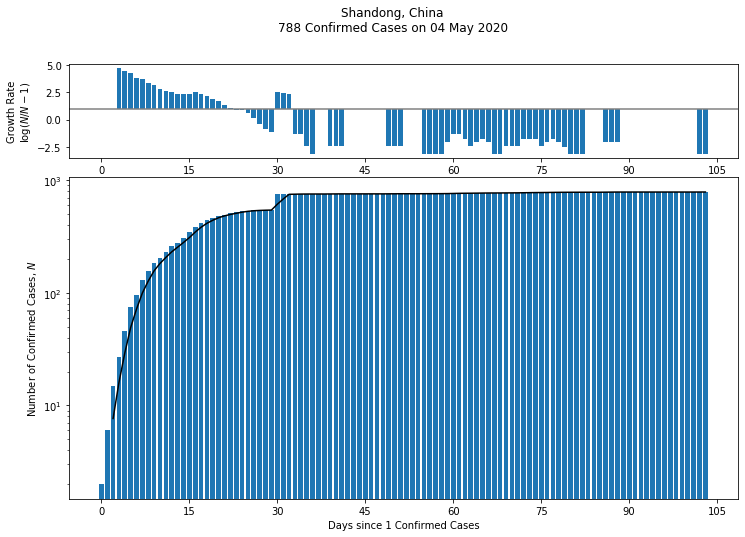

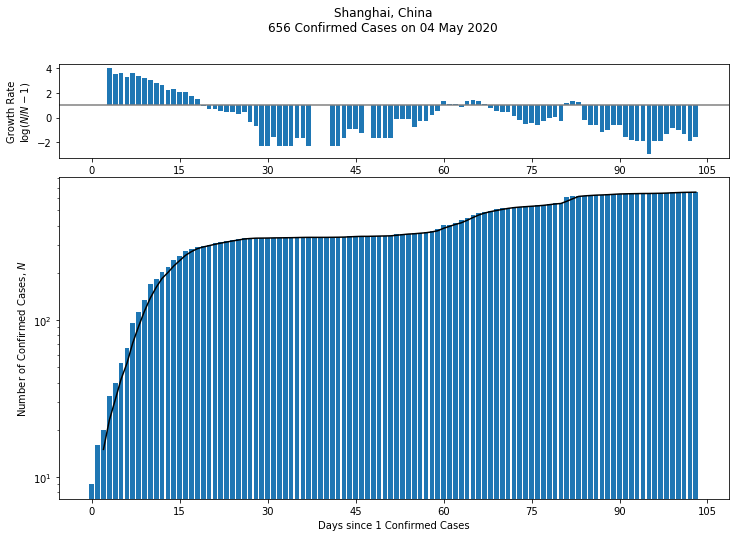

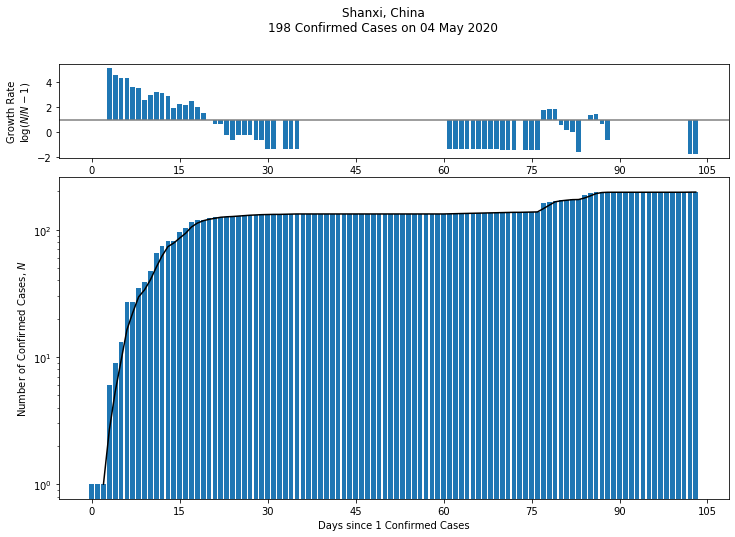

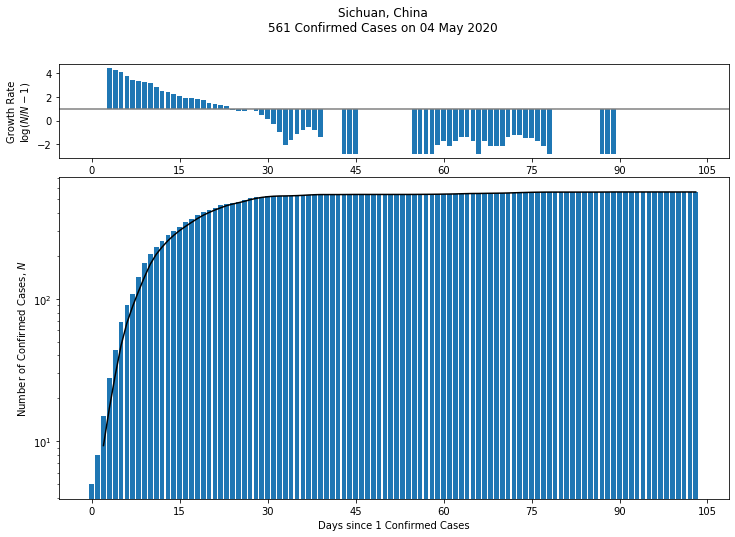

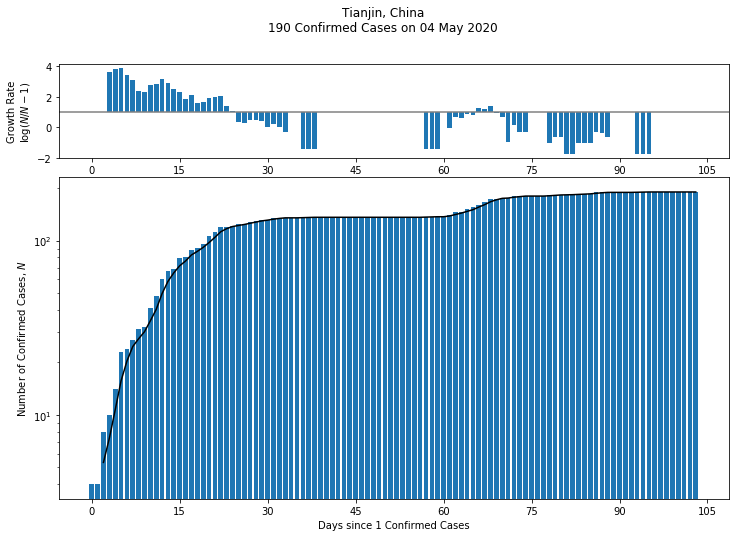

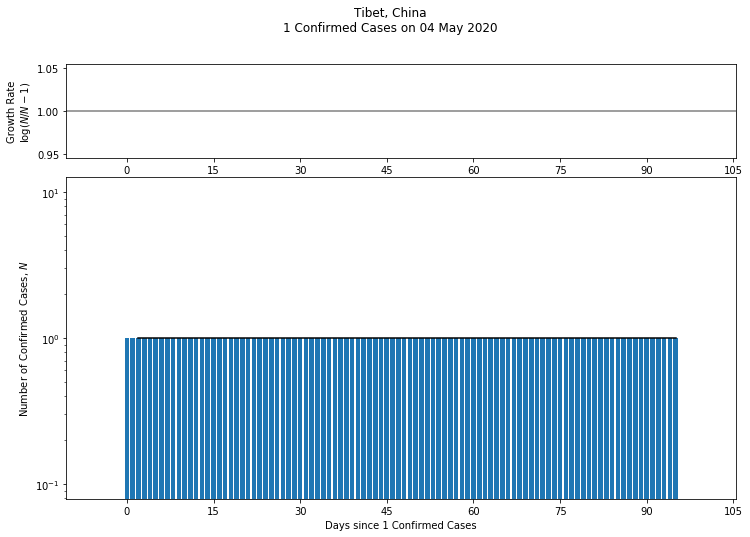

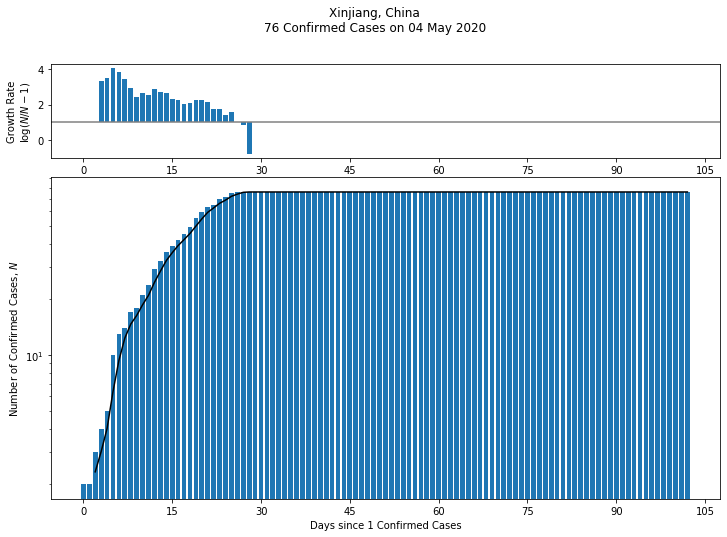

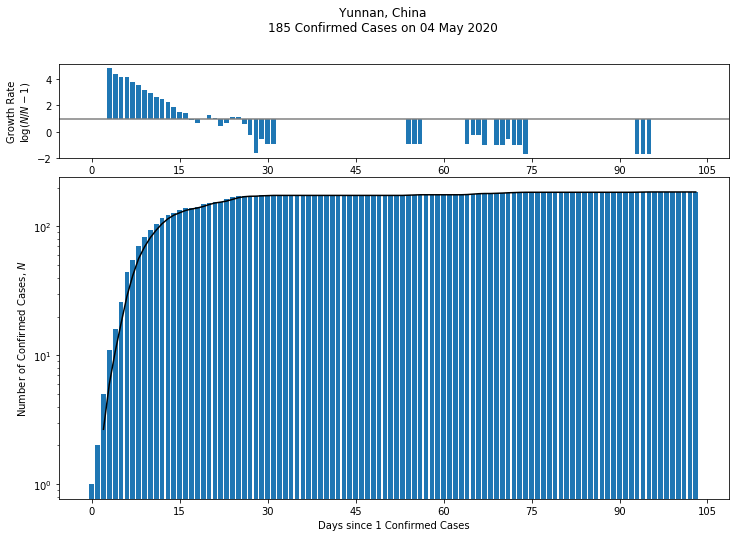

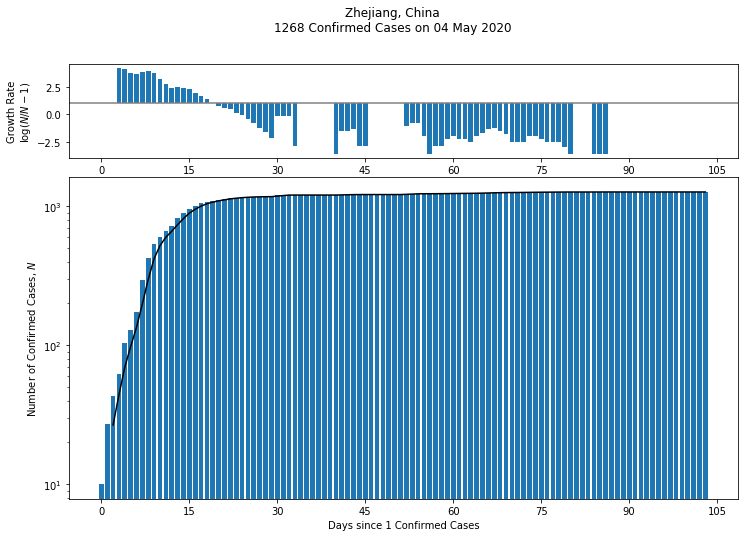

In [10]:
plot_states_of_country('China')
#plot_all_countries() # slow!

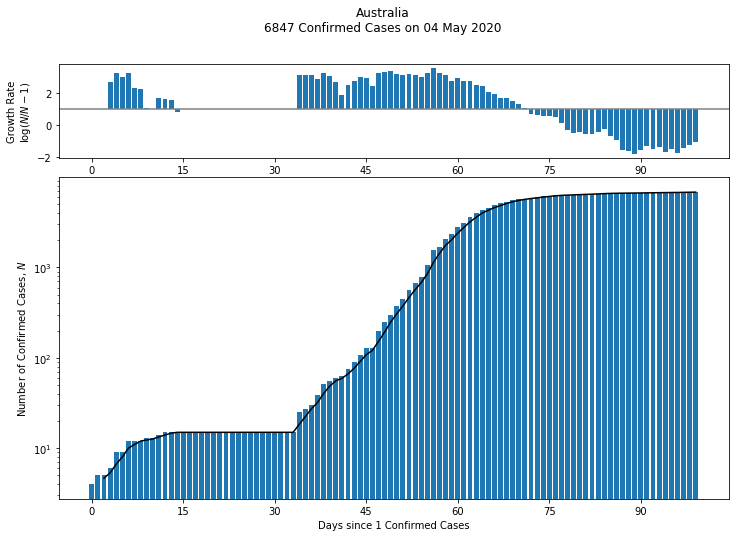

In [11]:
gfig = None
def interact_plot(country):
    # Plot the result
    global gfig
    if gfig is not None: plt.close(gfig)
    gfig = plot_country(country,state=None)


interact(interact_plot,
        country = Dropdown(options=country_list, value='Australia', description='Country:', disabled=False));